# Introduction

This notebook serves as report for the Machine Learning module of the Nantes Universiy Master Degree of Computing Science.
Louis Boursier on may 19, 2020.

The goal is to build a model that will predict the future number of cases according to the past numbers of cases. The model will be trained on several european countries data records, and will be tested on a new one.


# Data introduction

[The dataset has been found on Kaggle](https://www.kaggle.com/optimo/covid19-enriched-dataset-week-2). It is called *Covid19_Enriched_Dataset_week_2* and is a gather of different files. It contains information about the coronavirus and others relevant variables that may be required in order to predict Covid's progression. That information was gathered from the OECD site and some other government sites and is up to date (March 2020). Whatever was missing has been filled from Wikipedia with data that is actual for 2018.


It is under [Open Database license](https://opendatacommons.org/licenses/dbcl/1.0/) which allows us to freely share, modify, and use a database while maintaining this same freedom for others.

**The first thing to bear in mind is that it does not really make sense to compare countries with one another.** Indeed, each country has its own way of keeping record of its deaths. On one extreme, there is Belgium, that includes death in hospitals, care homes but also any death where the virus is suspected to have play a part. On the other, we have some countries that have suspiciously low cases numbers. This might explain why Belgium is the country that suffers the most in proportion, according to the data.

Moreover, because countries have different policies on testing, the number of case can also not be compared between them. Worse, the testing policy can change inside a country and bias data if it is not taken into account. For example, France decided to include deaths in nursing home several week after the begining of the spread of the disease. This resulted in an  (artifical) spike in the number of deaths.

Finally, Covid's casualities and progression are probably correlated with a significant amount of variables that are not in this dataset, and they may be needed for building a good predictive model.

A solution would be to treat each country individually. The problem is that there are only roughly 60 rows per country which is not much for any kind of machine learning project.

In [218]:
import pandas as pd

df = pd.read_csv("enriched_covid_19_week_2.csv")
df.shape

(18816, 38)

The dataset contains 18816 rows of 38 distinct variables.

It contains both information direclty related to the Covid, like the **ConfirmedCases**, and more general information like **smokers_perc**. We notice the artifical variable **Id** that we should remove.

# Data preparation

## Feature selection

We can also remove the **Province_State**, as we will not use it. We remove the **Date** because **rows are already ordered and the sequence of apparition is enough for the future model**.

In [219]:
df.drop(['Id'], 1, inplace=True)
df.drop(['Province_State'], 1, inplace=True)
df.drop(['Date'], 1, inplace=True)

## Data type checking

We should identify wrong types like *NaN*, empty or wrong values. None have been seen.

## Data exploration

In [220]:
# Pick a few countries to get an overview

spain =  df[df.Country_Region == 'Spain']
italy =  df[df.Country_Region == 'Italy']
france =  df[df.Country_Region == 'France']
belgium =  df[df.Country_Region == 'Belgium']
uk =  df[df.Country_Region == 'United Kingdom']
germany =  df[df.Country_Region == 'Germany']

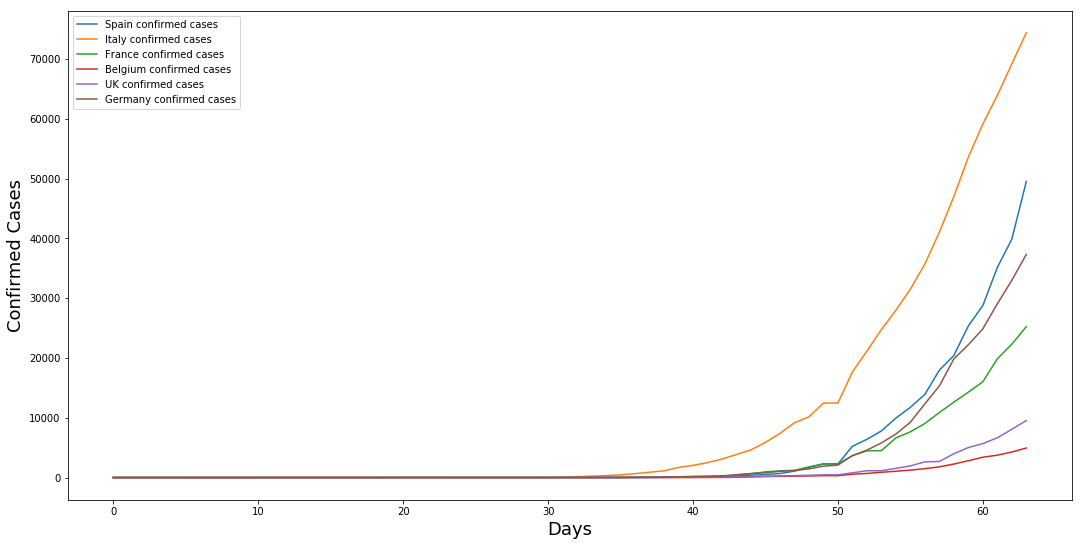

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(range(spain.shape[0]),spain['ConfirmedCases'],\
         label="Spain confirmed cases")
plt.plot(range(italy.shape[0]),italy['ConfirmedCases'],\
         label="Italy confirmed cases")
plt.plot(range(france.shape[0]),france['ConfirmedCases'],\
         label="France confirmed cases")
plt.plot(range(belgium.shape[0]),belgium['ConfirmedCases'],\
         label="Belgium confirmed cases")
plt.plot(range(uk.shape[0]),uk['ConfirmedCases'],\
         label="UK confirmed cases")
plt.plot(range(germany.shape[0]),germany['ConfirmedCases'],\
         label="Germany confirmed cases")
plt.xlabel('Days',fontsize=18)
plt.ylabel('Confirmed Cases',fontsize=18)
plt.legend(loc="upper left")
plt.show()

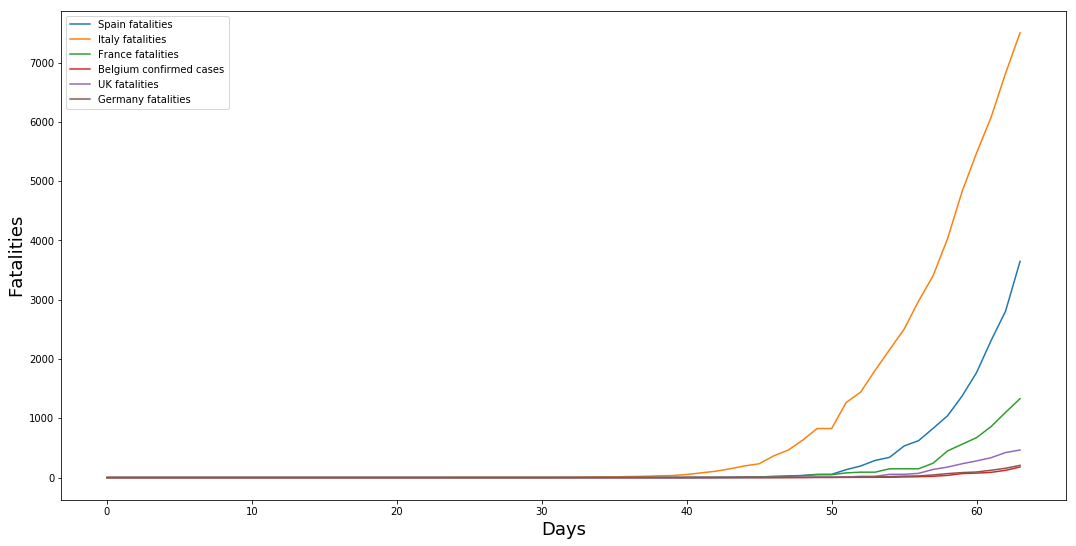

In [225]:
plt.figure(figsize = (18,9))
plt.plot(range(spain.shape[0]),spain['Fatalities'],\
         label="Spain fatalities")
plt.plot(range(italy.shape[0]),italy['Fatalities'],\
         label="Italy fatalities")
plt.plot(range(france.shape[0]),france['Fatalities'],\
         label="France fatalities")
plt.plot(range(belgium.shape[0]),belgium['Fatalities'],\
         label="Belgium confirmed cases")
plt.plot(range(uk.shape[0]),uk['Fatalities'],\
         label="UK fatalities")
plt.plot(range(germany.shape[0]),germany['Fatalities'],\
         label="Germany fatalities")
plt.xlabel('Days',fontsize=18)
plt.ylabel('Fatalities',fontsize=18)
plt.legend(loc="upper left")
plt.show()

The number of cases seems to correlate with the number of deaths.

We remove the variable **Country_Region** as we want our model to generalize over different countries so that it can predict for a country it has not seen during training. We also remove other variables to begin with a lower dimension space. We might bring them back later.

We split the data **manually** between training set (2/3) and testing set (1/3). It is important to split the training and testing set at an index which is a multiple of 64, so that we do not scatter a country data accross testing an training set. 

In [226]:
lines_count = df.shape[0]
lines_per_country = 64

country_count = int(lines_count / lines_per_country)
train_country_count = int(country_count * (2/3))
test_country_count = int(country_count * (1/3))

train_rows_count = int(lines_count * (2/3))
test_rows_count = int(lines_count * (1/3))

print('Country count: ' + str(country_count))
print('Train rows count: ' + str(train_rows_count))
print('Test rows count: ' + str(test_rows_count))
print('Train country count: ' + str(train_country_count))
print('Test country count: ' + str(test_country_count))

Country count: 294
Train rows count: 12544
Test rows count: 6272
Train country count: 196
Test country count: 98


In [227]:
# There are 18816 lines
# each country is made up of 64 lines

simplified_df = df[['ConfirmedCases','total_pop']]

simplified_df.shape

(18816, 2)

In [230]:
from sklearn.preprocessing import MinMaxScaler

# Normalize

scaler = MinMaxScaler()

reshaped = array(simplified_df.ConfirmedCases.values).reshape(-1, 1)
scaler.fit(reshaped)
print(scaler.data_max_)
print(scaler.data_min_)
normalized = scaler.transform(reshaped)
simplified_df['ConfirmedCases'] = normalized

reshaped = array(simplified_df.total_pop.values).reshape(-1, 1)
scaler.fit(reshaped)
print(scaler.data_max_)
print(scaler.data_min_)
normalized = scaler.transform(reshaped)
simplified_df['total_pop'] = normalized

simplified_df.describe()

[1.]
[0.]
[1.]
[0.]


C:\Users\loutouk\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\loutouk\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ConfirmedCases,total_pop
count,18816.000000,18816.000000
mean,0.004613,0.172518
std,0.048129,0.310446
min,0.000000,0.000000
25%,0.000000,0.006149
50%,0.000000,0.025867
75%,0.000202,0.232174
max,1.000000,1.000000


In [231]:
x_train = simplified_df.head(train_rows_count)
x_test = simplified_df.tail(test_rows_count)

In [232]:
y_train = x_train['ConfirmedCases']
y_test = x_test['ConfirmedCases']

There is a sequence of 64 consecutive days for each country. We will split the dataframe into subsequences of 63 time steps. The following and final time step will be the prediction used for training: we will train the model to predict the number of cases on the 64th day according to the previous 63 days.

In [233]:
x_days_train = list()
y_days_train = list()
length = lines_per_country
country_count = train_country_count
for i in range(0,length*country_count,length):
    x_day_train = x_train[i:i+length-1]
    x_days_train.append(x_day_train.values)
    y_day_train = y_train[i+length-1:i+length]
    y_days_train.append(y_day_train.values)
print(len(x_days_train))
print(len(y_days_train))

196
196


In [234]:
import numpy as np
from numpy import array

# The LSTM needs data with the format of [samples, time steps and features]
# Here, we have 196 samples, 63 time steps per sample, and 2 features
# First, we need to convert our list of arrays into a 2D NumPy array of 196 x 2

# convert list of arrays into 2d array
x_train = array(x_days_train)
print(x_train.shape)
y_train = array(y_days_train)
print(y_train.shape)

(196, 63, 2)
(196, 1)


In [235]:
# Next, we can use the reshape() function 
# to add one additional dimension for our features

# reshape into [samples, timesteps, features]
# expect [196, 63, 2]

x_train = x_train.reshape(train_country_count, 63, 2)
print(x_train.shape)

(196, 63, 2)


In [236]:
# Create test set

x_days_test = list()
y_days_test = list()
length = lines_per_country
country_count = test_country_count
for i in range(0,length*country_count,length):
    x_day_test = x_test[i:i+length-1]
    x_days_test.append(x_day_test.values)
    y_day_test = y_test[i+length-1:i+length]
    y_days_test.append(y_day_test.values)
print(len(x_days_test))
print(len(y_days_test))

x_test = array(x_days_test)
print(x_test.shape)
y_test = array(y_days_test)
print(y_test.shape)

x_test = x_test.reshape(test_country_count, 63, 2)
print(x_test.shape)

98
98
(98, 63, 2)
(98, 1)
(98, 63, 2)


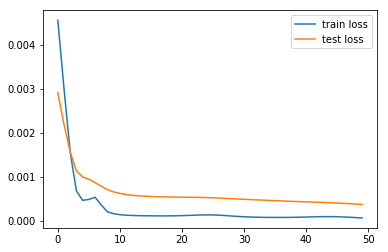

In [240]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from matplotlib import pyplot

# Define model
n_steps = 63
n_features = 2
n_batch = 4
model = Sequential()
model.add(LSTM(16, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit network
history = model.fit(x_train, y_train, epochs=50,\
                    batch_size=n_batch, validation_data=(x_test, y_test),\
                    verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test loss')
pyplot.legend()
pyplot.show()

In [241]:
predictions = model.predict(x_test)

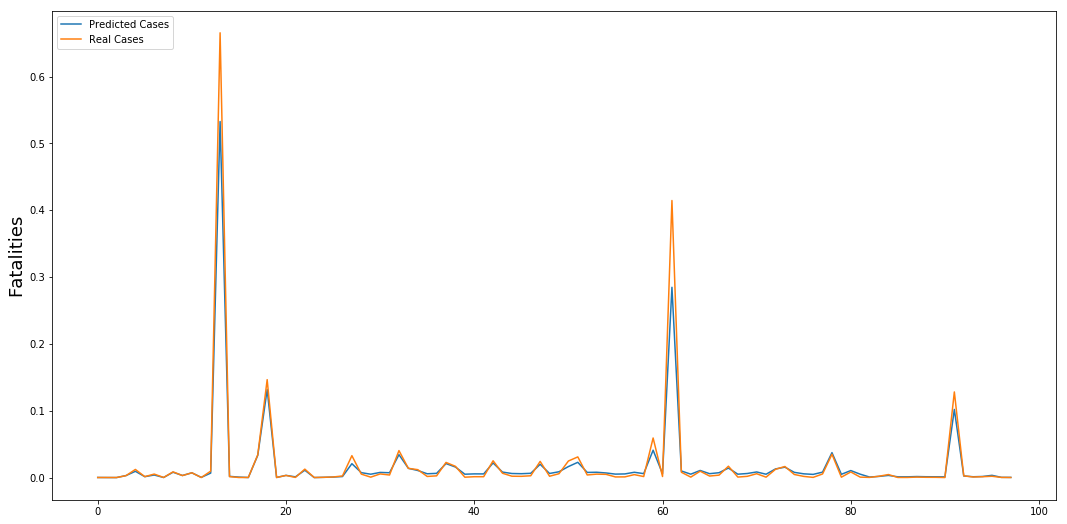

In [242]:
inversed_pred = scaler.inverse_transform(predictions)
inversed_real = scaler.inverse_transform(y_test)
    
plt.figure(figsize = (18,9))
plt.plot(range(len(inversed_pred)),inversed_pred, label="Predicted Cases")
plt.plot(range(len(inversed_real)),inversed_real, label="Real Cases")
plt.ylabel('Fatalities',fontsize=18)
plt.legend(loc="upper left")
plt.show()

We can see that the model is relatively accurate for predicting the number of cases on the 64th day according to the last 63 days. It has been tested on more than 6000 unseen countries. The result should not be a suprise, as this is really a easy task that a human can do as well. A more interesting approach could be to group days into weeks, and to try to predict the result of the next week(s) according to previous weeks.

In [212]:
# Serialize model to JSON

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [243]:
from keras.models import model_from_json

# Later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mse')
score = loaded_model.evaluate(x_test, y_test, verbose=0)
prediction = loaded_model.predict(x_test)

Loaded model from disk
